<a href="https://www.kaggle.com/code/sagnikdebnath007/image-inpainting?scriptVersionId=211168580" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

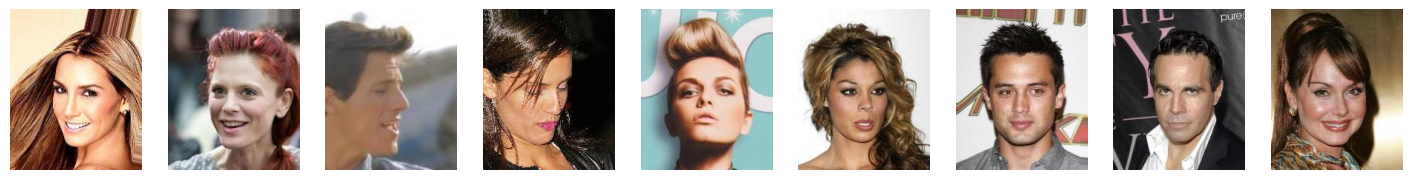

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.4)

for i in range(1,10):   
    plt.subplot(1,10,i+1)    
    filename = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/00000' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.axis('off')
plt.show()

In [9]:
import os
import torch 
import torch.nn as nn #nn layers
import torch.optim as optim #optimization algos
import torch.nn.functional as F #activation funcs like relu,tanh. Also included in nn
from torch.utils.data import Dataset,DataLoader,random_split #Makes data using easy
import torchvision.datasets as datasets #for datasets
import torchvision.transforms as transforms #used for data augmentation
from PIL import Image

In [10]:
class DatasetLoader(Dataset):
    def __init__(self,root,transform=False):
        self.root=root
        self.transform=transform
        self.img_paths=sorted(os.listdir(os.path.join(root, "img_align_celeba")))
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "img_align_celeba", self.img_paths[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [11]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [12]:
dataset=DatasetLoader(root='/kaggle/input/celeba-dataset/img_align_celeba',transform=transform)

In [13]:
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [14]:
class VariationalAutoencoder(nn.Module):
    def __init__(self,input_dim=3,latent_dim=128):
        super(VariationalAutoencoder,self).__init__()
        self.input_dim=input_dim
        self.latent_dim=latent_dim
        self.encoder=nn.Sequential(
            nn.Conv2d(input_dim,16,kernel_size=6,stride=4,padding=1),
            nn.SiLU(),
            nn.Conv2d(16,32,kernel_size=6,stride=4,padding=1),
            nn.SiLU(),
            nn.Conv2d(32,64,kernel_size=6,stride=4,padding=1),
            nn.SiLU()    
        )
        self.mu=nn.Linear(64*4*4,latent_dim)
        self.logvar=nn.Linear(64*4*4,latent_dim)
        self.inver_flatten=nn.Linear(latent_dim,64*4*4)
        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(64,32,kernel_size=6,stride=4,padding=1),
            nn.SiLU(),
            nn.ConvTranspose2d(32,16,kernel_size=6,stride=4,padding=1),
            nn.SiLU(),
            nn.ConvTranspose2d(16,input_dim,kernel_size=6,stride=4,padding=1),
            nn.Tanh()
        )

    def reparameterize(self,mu,logvar):
        eps=torch.randn_like(logvar)
        sigma=torch.exp(0.5*logvar)
        z=mu+eps*sigma
        return z
    def forward(self,x):
        batch_size=x.shape[0]
        encoded=self.encoder(x).view(batch_size,-1)
        mu=self.mu(encoded)
        logvar=self.logvar(encoded)
        z=self.reparameterize(mu,logvar)
        inverse_flattened=self.inver_flatten(z).view(batch_size,64,4,4)
        decoded=self.decoder(inverse_flattened)
        return decoded,mu,logvar

In [18]:
model=torch.load('/kaggle/input/vae/pytorch/default/1/entire_model.pth')
model.load_state_dict(torch.load('/kaggle/input/vae-weights/pytorch/default/1/model_state_dict.pth'))

/tmp/ipykernel_23/1322687565.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load('/kaggle/input/vae/pytorch/default/1/entire_model.pth')
/tmp/ipykernel_23/1

<All keys matched successfully>

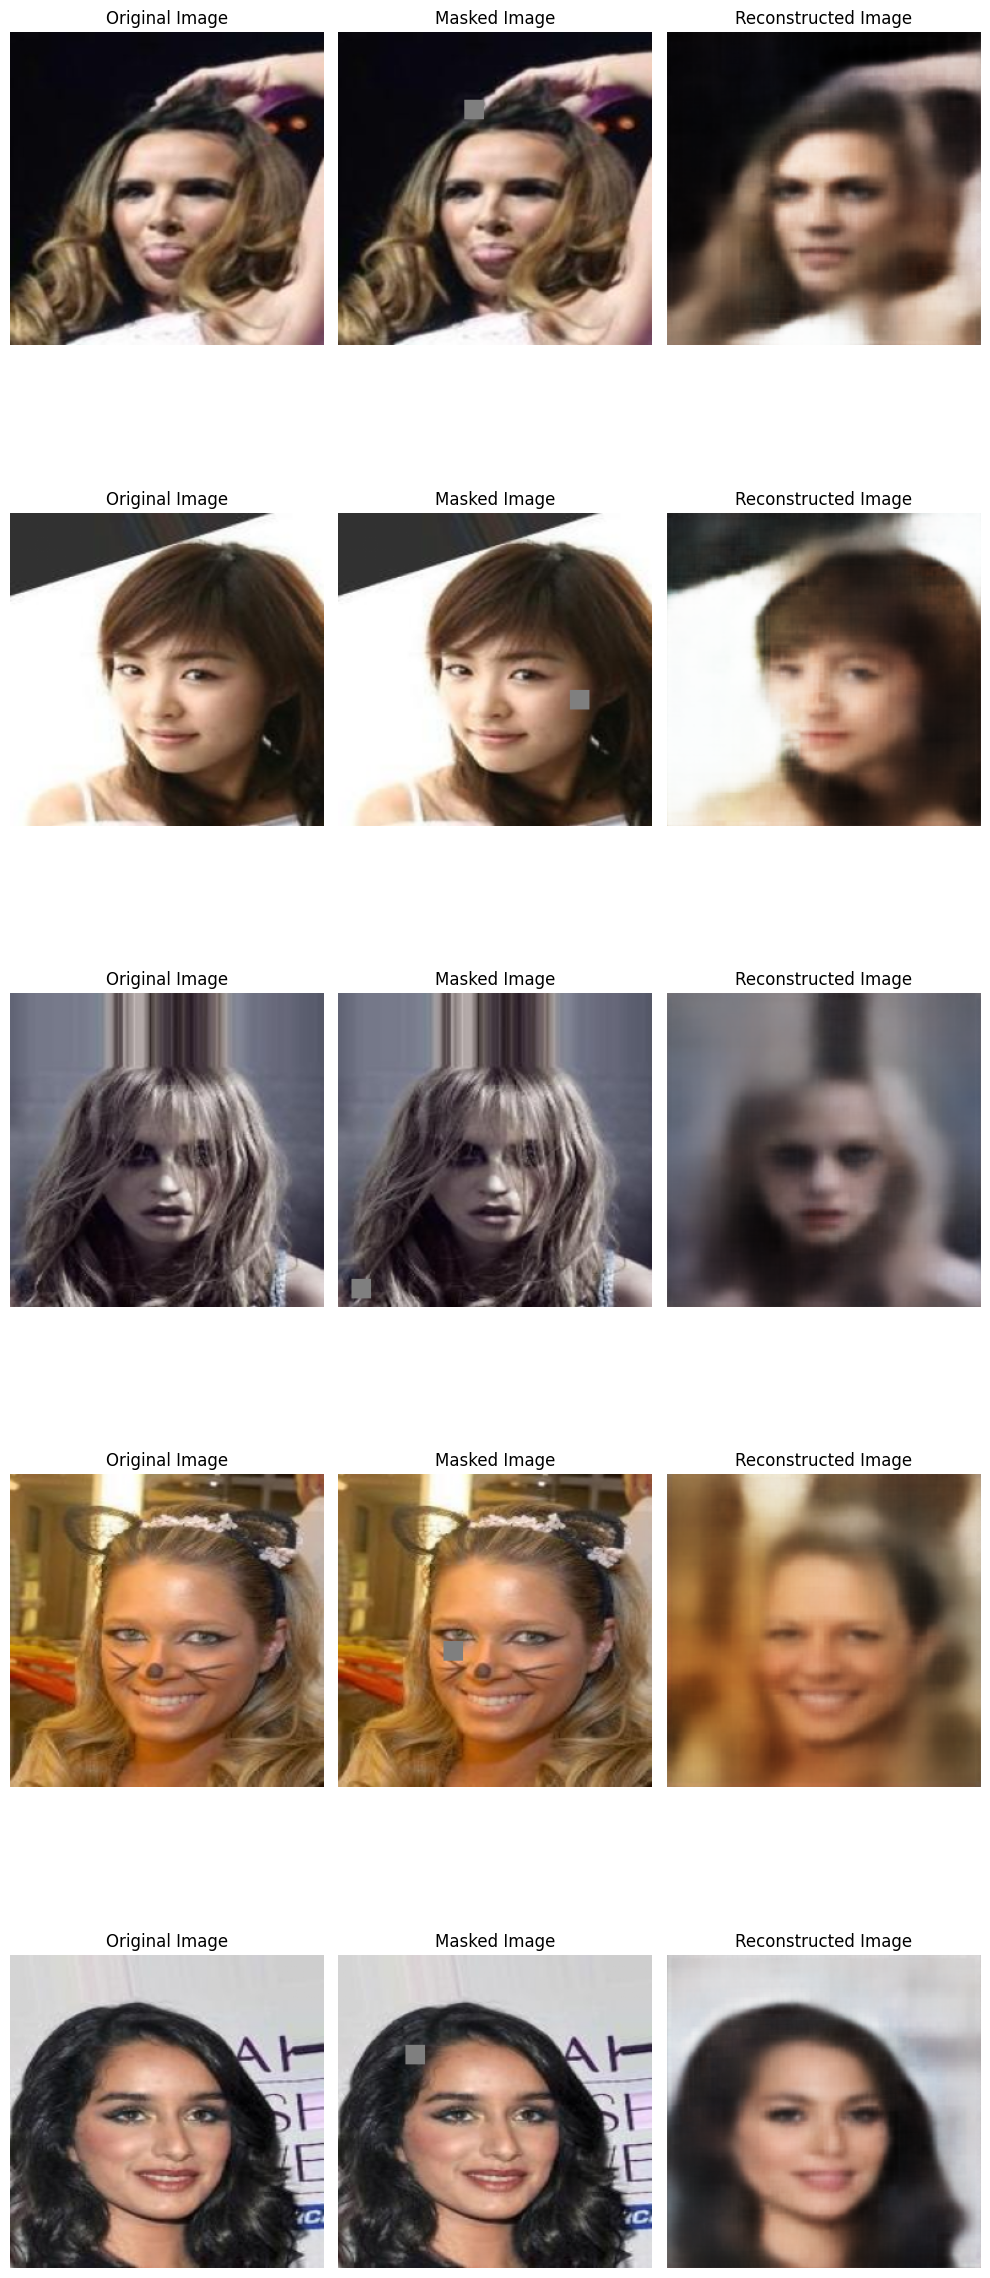

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def apply_random_mask(images, mask_size=16):
    B, C, H, W = images.size()
    masked_images = images.clone()
    mask = torch.ones_like(images) 

    for i in range(B):
        top = torch.randint(0, H - mask_size, (1,))
        left = torch.randint(0, W - mask_size, (1,))
        masked_images[i, :, top:top+mask_size, left:left+mask_size] = 0
        mask[i, :, top:top+mask_size, left:left+mask_size] = 0

    return masked_images, mask

def visualize_inpainting(model, val_loader, mask_size=16, num_images=5):
    model.eval()
    with torch.no_grad():
        # Get a batch of validation data
        images = next(iter(val_loader))
        images = images.to('cuda')

        # Apply random masks
        masked_images, mask = apply_random_mask(images, mask_size=mask_size)

        # Reconstruct images
        reconstructed, _, _ = model(masked_images)

    # Denormalize for visualization
    images = torch.clamp(images * 0.5 + 0.5, 0, 1).cpu()
    masked_images = torch.clamp(masked_images * 0.5 + 0.5, 0, 1).cpu()
    reconstructed = torch.clamp(reconstructed * 0.5 + 0.5, 0, 1).cpu()

    # Visualize
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 5 * num_images))
    for i in range(num_images):
        axes[i, 0].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(np.transpose(masked_images[i].numpy(), (1, 2, 0)))
        axes[i, 1].set_title("Masked Image")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(np.transpose(reconstructed[i].numpy(), (1, 2, 0)))
        axes[i, 2].set_title("Reconstructed Image")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


# Visualize results
visualize_inpainting(model, val_loader, mask_size=16, num_images=5)